In [1]:
!hostname

gnode011.cluster


In [2]:
!nvidia-smi

Mon Jun 26 14:51:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:31:00.0 Off |                    0 |
| N/A   32C    P0    62W / 300W |  12010MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

1.13.0+cu117
11.7


200.0
(1500, 400)
CPU times: user 1.28 s, sys: 29.1 ms, total: 1.3 s
Wall time: 1.44 s


Text(0.5, 1.0, 'Position Solution of the anharmonic Langevin dynamics with $\\gamma=1$ and $\\beta=1$')

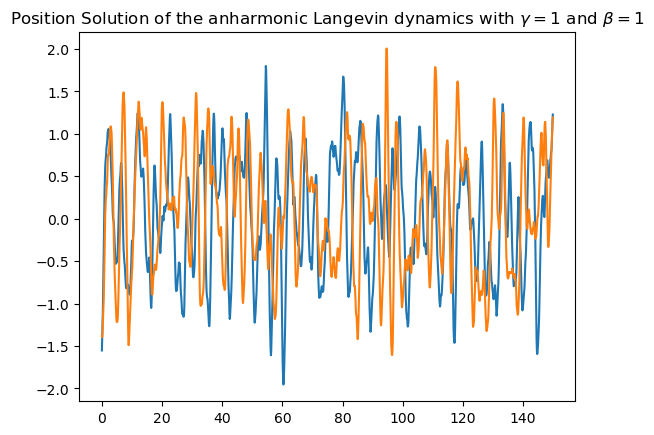

In [7]:
%%time

#### Generating SINN training data by solving SDE (Langevin dynamics)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad


def V_FPU(x,U0,x0):
    v=U0/x0**4*x**3+U0/x0**2*x      # FPU potential 
    return v


#### Parameters 
gamma = 1                              # coupling constant 
beta = 1                               # Inverse temperature, i.e. T=1/beta
dt = 0.01                              # Step-size of the SDE solver 
delta_t = 0.1                          # Step-size of the temporally coarse-grained path
batch = 400                            # Batch size 
sec_length = 400                       # Length of the input sequence 
U0 = 1                                 # FPU parameter, depth of the well 
x0 = 1                                 # FPU parameter, position of the basin 

#### SDE solver (EM scheme) 
Time = 5*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length) # define time axis
gap=int(delta_t/dt)
t_store=t[0:-1:gap]
q_store = np.zeros([t_store.size+1,batch])

# q_store = np.zeros([t_store.size+1,batch])
p1=np.zeros((2,batch))
q1=np.zeros((2,batch))


# solve SDE
j=1
for i in range(1,length):
     q1[1,:] = q1[0,:] + p1[0,:]*dt
     p1[1,:] = p1[0,:] + (-V_FPU(q1[0,:],U0,x0)-gamma*p1[0,:])*dt + np.random.randn(1,batch)*np.sqrt(2*dt*gamma/beta)
     if i % gap ==0:            
            q_store[j,:]=q1[1,:]
            j=j+1
     p1[0,:]=p1[1,:]
     q1[0,:]=q1[1,:]


Toss=int(t_store.size/4)
q_store=q_store[Toss:-1,:]
print(q_store.shape)



plt.figure(0)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,i])
# plt.legend()
plt.title(r"Position Solution of the anharmonic Langevin dynamics with $\gamma=1$ and $\beta=1$")
# plt.savefig("figs/FPU_dt016.pdf", dpi=150)



In [8]:
# Construct the sample traj for SINN learning 
ini=np.random.randn(sec_length,batch)
Traj=q_store[0:sec_length,:]
print(ini.shape, Traj.shape)


T=np.arange(len(Traj[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(Traj.shape)

(400, 400) (400, 400)
(400, 400)


In [9]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 1), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 1)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 1]) torch.float32
The torch validation size is torch.Size([800, 400, 1]) torch.float32
The torch target size is torch.Size([400, 400, 1]) torch.float32


In [10]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_q2 = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)
loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)

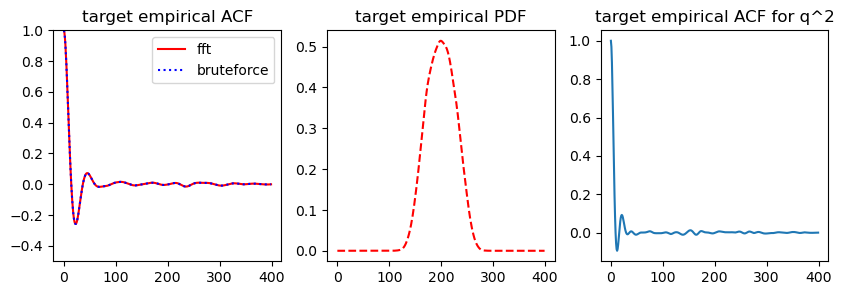

In [11]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].plot(loss_acf_fft._target.cpu(),'r', label='fft')
axs[0].plot(loss_acf_bruteforce._target.cpu(),'b:', label='bruteforce')
axs[0].set_title('target empirical ACF')
axs[0].set_ylim([-0.5,1])
x_grid=-np.linspace(-5,5,num=sec_length)
axs[1].plot(loss_pdf_empirical._target.cpu(),'r--')
axs[1].set_title('target empirical PDF')
axs[2].plot(loss_acf_q2._target.cpu())
axs[2].set_title('target empirical ACF for q^2')
axs[0].legend()
plt.show()

In [12]:
### Defining SINN model
net = SINN(1, 5, 2, 1).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [14]:
%%time
# Training SINN
T_error=[]
V_error=[]
T_acf=[]
V_acf=[]
T_pdf=[]
V_pdf=[]
T_acf2=[]
V_acf2=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction) + loss_pdf_empirical(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val) + loss_acf_q2(pred_val**2)
            acf = loss_acf_bruteforce(pred_val)
            pdf = loss_pdf_empirical(pred_val)
            acf_sec_moment = loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, pdf: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, pdf, acf_sec_moment))
            T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
            V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
            T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
            V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
            T_acf2.append(loss_acf_q2(prediction**2).detach().cpu().numpy())
            V_acf2.append(loss_acf_q2(pred_val**2).detach().cpu().numpy())
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.0005 and loss_val<=0.0005:
            break
print('Training finished')

[0]-th step loss: 0.2627, 0.2626, acf: 0.00777, pdf: 0.25332, acf2: 0.00156
[50]-th step loss: 0.2112, 0.2084, acf: 0.00546, pdf: 0.20226, acf2: 0.00070
[100]-th step loss: 0.0496, 0.0479, acf: 0.00332, pdf: 0.04195, acf2: 0.00268
[150]-th step loss: 0.0214, 0.0212, acf: 0.00348, pdf: 0.01561, acf2: 0.00212
[200]-th step loss: 0.0117, 0.0116, acf: 0.00321, pdf: 0.00761, acf2: 0.00075
[250]-th step loss: 0.0074, 0.0070, acf: 0.00291, pdf: 0.00356, acf2: 0.00050
[300]-th step loss: 0.0046, 0.0043, acf: 0.00217, pdf: 0.00167, acf2: 0.00045
[350]-th step loss: 0.0024, 0.0022, acf: 0.00113, pdf: 0.00083, acf2: 0.00028
[400]-th step loss: 0.0011, 0.0011, acf: 0.00040, pdf: 0.00049, acf2: 0.00020
[450]-th step loss: 0.0009, 0.0008, acf: 0.00026, pdf: 0.00036, acf2: 0.00019
[500]-th step loss: 0.0007, 0.0007, acf: 0.00021, pdf: 0.00033, acf2: 0.00020
[550]-th step loss: 0.0006, 0.0007, acf: 0.00019, pdf: 0.00030, acf2: 0.00019
[600]-th step loss: 0.0005, 0.0006, acf: 0.00018, pdf: 0.00025, acf

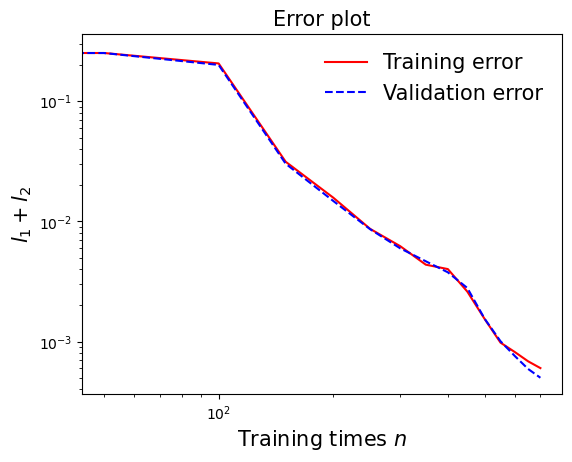

In [23]:
### ACF
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

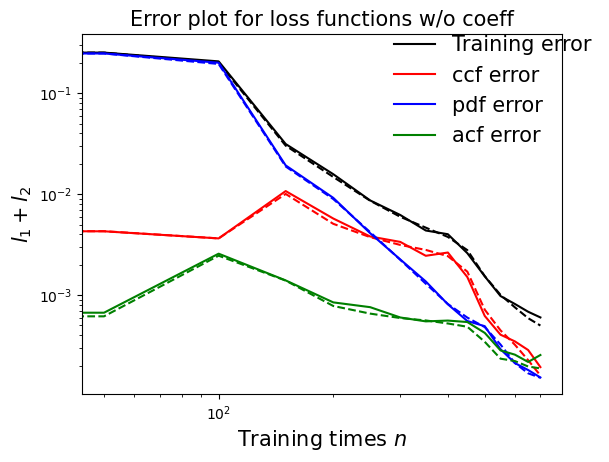

In [24]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot for loss functions w/o coeff",fontsize=15) 
plt.loglog(Step, T_error,'k',label='Training error')
plt.loglog(Step, V_error,'k--')
plt.loglog(Step, T_acf,'r',label='ccf error')
plt.loglog(Step, V_acf,'r--')
plt.loglog(Step, T_pdf,'b',label='pdf error')
plt.loglog(Step, V_pdf,'b--')
plt.loglog(Step, T_acf2,'g',label='acf error')
plt.loglog(Step, V_acf2,'g--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [27]:
# # Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred,_= net(ran_input)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch)

([<matplotlib.axis.YTick at 0x14a29287fd30>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

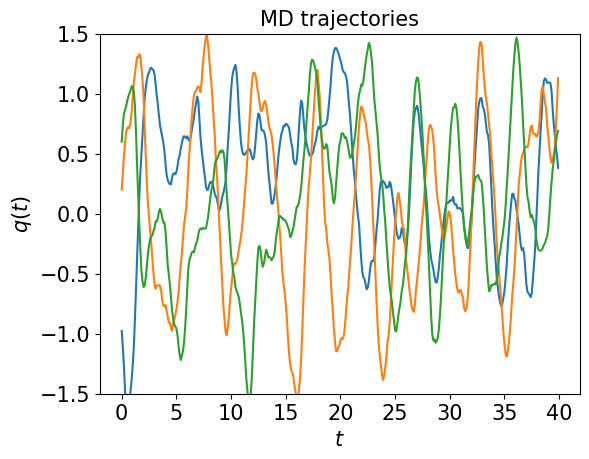

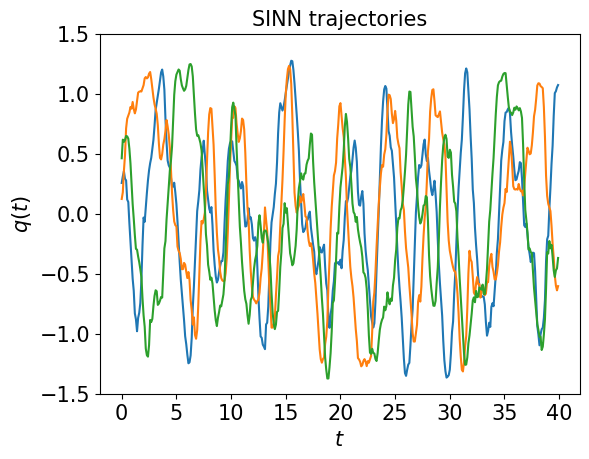

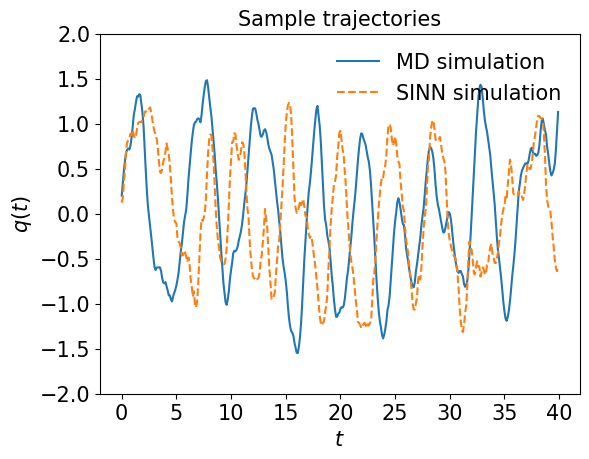

In [28]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.plot(T[skip:]-T[skip], Traj[skip:, 1])
plt.plot(T[skip:]-T[skip], Traj[skip:, 2])   
plt.ylim([-1.5,1.5])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
# plt.savefig("figs/FPU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
plt.plot(T[skip:]-T[skip], prediction[skip:, 1])
plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
plt.ylim([-1.5,1.5])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/FPU_traj_multi.pdf", dpi=150)


fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 1], label='MD simulation')
# plt.plot(T[skip:]-T[skip], Traj[skip:, 1],'r')
plt.plot(T[skip:]-T[skip], prediction[skip:, 1],'--',label='SINN simulation')
# plt.plot(T[skip:]-T[skip], prediction[skip:, 1],'b')
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)
# plt.savefig("figs/FPU_traj.pdf", dpi=150)





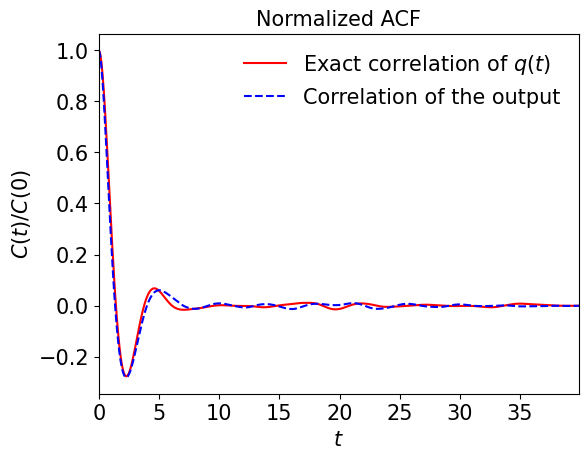

In [29]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF  

acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
corr_p=acf_p.mean(axis=1).detach().cpu().numpy()
corr_t=acf_t.mean(axis=1).detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t,'r',label=r'Exact correlation of $q(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0,T[-1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

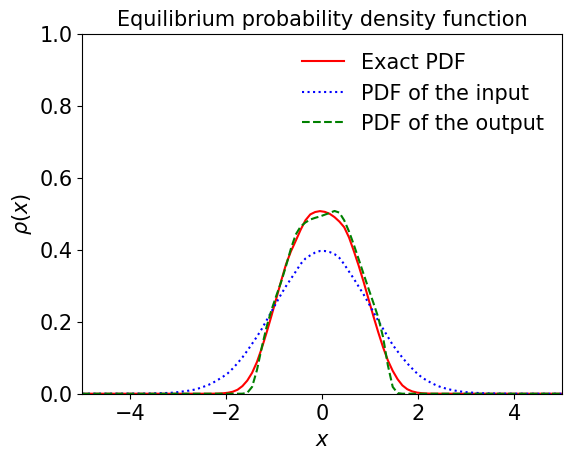

In [32]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
rho_data =  StatLoss.gauss_kde(target, -5, 5, 100,None).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100,None).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100,None).cpu()


x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy(), 'r',label=r'Exact PDF')    # target PDF
plt.plot(x, rho_input.numpy(), 'b:', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy(), 'g--',label=r'PDF of the output')  # PDF after the training 
plt.xlim(-5,5)
plt.ylim(0,1)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

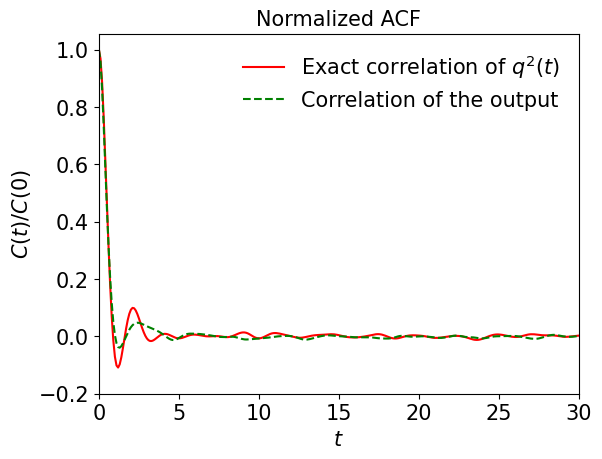

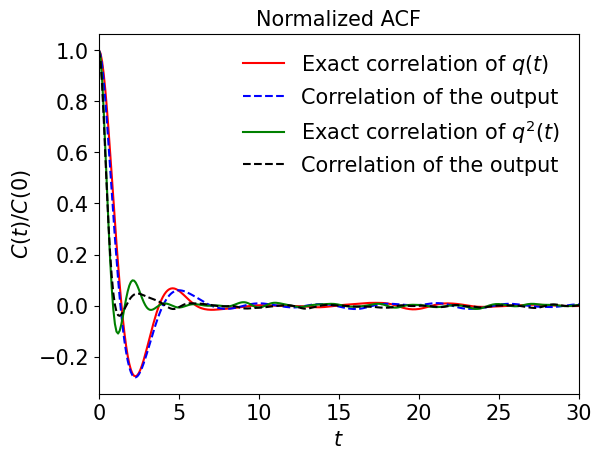

In [36]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,1))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/FPU_acf2.pdf", dpi=150)


fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)  
plt.plot(T, corr_t,'r',label=r'Exact correlation of $q(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')   
plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

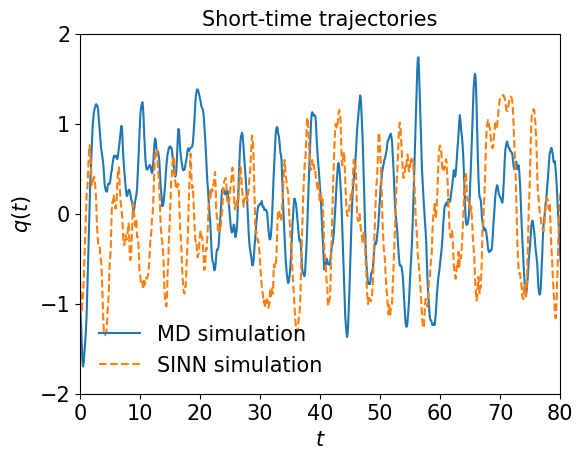

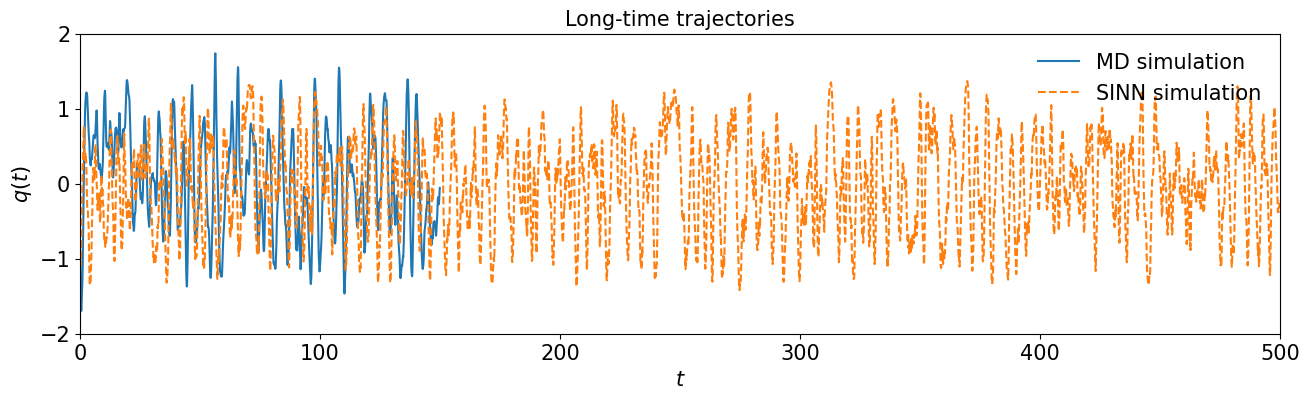

In [37]:
# Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
[a,b,c]=input.size()
skip=20
scale=10
burnin=3
fold=800
batch_new=50
ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
Pred_L, _= net(ran_input)
prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new)
acf_p=StatLoss.acf(Pred_L,method='bruteforce')

LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
LT=LT[0:-1]


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1],'--',label='SINN simulation')
plt.xlim([0,80])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1],'--',label='SINN simulation')
plt.xlim([0,500])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_lT.pdf", dpi=150)




In [38]:
### Defining SINN model
net = SINN(1, 5, 2, 1).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)